# Ques 12 -18

公式推导与思想见书，我一开始没理解题目要干什么（）

要干的可见这个链接：https://blog.csdn.net/v_july_v/article/details/40718799
算法总流程这篇也相当值得借鉴：https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/


skicit-learn 中实际上包括了adaboost算法，但是分类器默认的是决策树

https://scikit-learn.org.cn/view/174.html

后面会说明好像decision tree会比adaboost更优秀，后面一个代码块也实验了下

https://scikit-learn.org.cn/view/784.html         决策树CART

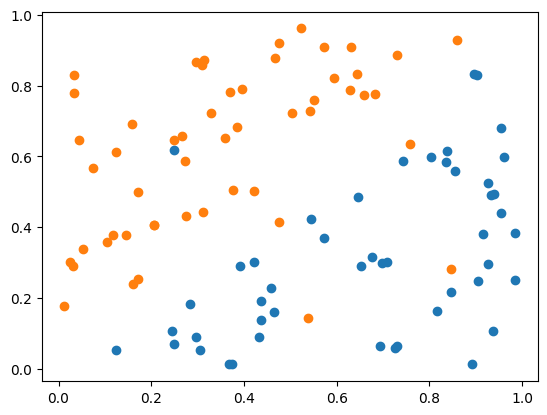

In [1]:
##-------------------step1: data loading------------------#
iterations = 300
infinite = -1e10

#-----------data reading--------------#
import numpy as np
training_data = np.loadtxt('hw6_adaboost_train.dat')
X = training_data[:, :-1]
Y = training_data[:, -1]
(row_n,column_n) = np.shape(X)
#-----------data ploting---------------#
import matplotlib.pyplot as plt
plt.scatter(training_data[:,0][training_data[:,-1]==1],training_data[:,1][training_data[:,-1]==1])
plt.scatter(training_data[:,0][training_data[:,-1]==-1],training_data[:,1][training_data[:,-1]==-1])
plt.show()


In [26]:
##-------------step2 根据题设确立弱分类器集与针对的feature------------------##
training_data1  = np.array(sorted(training_data,key=lambda x:x[0]))
training_data2 = np.array(sorted(training_data,key = lambda x:x[1]))

x1 = training_data1[:,0]
# 对于feature1设置所有的阈值
theta1 = np.append(np.array(x1[0]-0.1),(x1[:-1]+x1[1:])/2)
theta1 = np.append(theta1, x1[-1] + 0.1)

x2 = training_data2[:,0]
# 对于feature2设置所有的阈值
theta2 = np.append(np.array(x2[0]-0.1),(x2[:-1]+x2[1:])/2)
theta2 = np.append(theta2, x2[-1] + 0.1)
#各个feature阈值合并
theta = np.c_[theta1,theta2]

y = training_data[:, 2]
X = training_data[:, :2]

def decision_stump(X,y,U,theta):
    """
    target:针对某个feature训练找到最好的stump
    X训练data,ylabel,U data 权重,theta:decision stump
    """
    n = theta.shape[0]                       #number of basic classifiers in this ques 
    m = X.shape[0]

    X = np.tile(X,(n,1))                     #copy X（横向平移） 

    y1 = np.sign(X-theta)                    #分类前-1后1
    y2 = -np.sign(X-theta)                   #分类前1后-1

    error1 = np.sum((y1!=y)*U,axis=1)        #axis为1时，sum按行加得到和
   
    error2 = np.sum((y2!=y)*U,axis=1)

    stump1 = np.argmin(error1)
    stump2 = np.argmin(error2)

    if error1[stump1]<error2[stump2] :
        s = 1
        index = stump1
        error = error1[stump1]/m
    else:
        s = -1
        index = stump2
        error = error2[stump2]/m
    return s,index,error

def decision_stump_all(X, y, U, theta):
    """
    对两个维度分别使用decision_stump,取误差较小的维度
    """
    #维度1
    X1 = X[:, 0]
    theta1 = theta[:, 0].reshape(-1, 1)
    s1, i1, e1 = decision_stump(X1, y, U, theta1)
    #维度2
    X2 = X[:, 1]
    theta2 = theta[:, 1].reshape(-1, 1)
    s2, i2, e2 = decision_stump(X2, y, U, theta2)
    if(e1 < e2):
        return (e1, s1, 0, i1)
    else:
        return (e2, s2, 1, i2)
 



In [28]:
##------------------step3 Algorithm Running--------------------##
def adaboost(X,y,theta,iterations=300):
    n = X.shape[0]
    u = np.ones(n)/n              #initialize weights

    Alpha = np.array([])
    U = np.array([])
    Epsilon = np.array([])
    Err = np.array([])
    G = np.array([])
   
    for t in range(iterations):
        (err , s , d , index) = decision_stump_all(X,y,u,theta)
        epsilon = u.dot((s * np.sign(X[:, d] - theta[:, d][index])) != y) / np.sum(u)
        #调整系数
        k = np.sqrt((1-epsilon)/epsilon)  
        #error data point
        i1 = s*np.sign(X[:,d]-theta[:,d][index]) != y
        #adjust wrong data weights
        u[i1]=u[i1]*k
        #right data point
        i2 = s*np.sign(X[:,d]-theta[:,d][index]) == y
        #adjust wrong data weights
        u[i2]=u[i2]/k
        alpha = np.log(k)

        Err = np.r_[Err,err] #row-wise merging
        if(t==0):
            U=np.array([u])
        else:
            U=np.r_[U,np.array([u])]
        Epsilon = np.r_[Epsilon,epsilon]
        Alpha = np.r_[Alpha,alpha]
        g = [[s,d,index]]

        if (t==0):
            G = np.array(g)
        else:
            G = np.r_[G,np.array(g)]
    return Err,U,Epsilon,Alpha,G


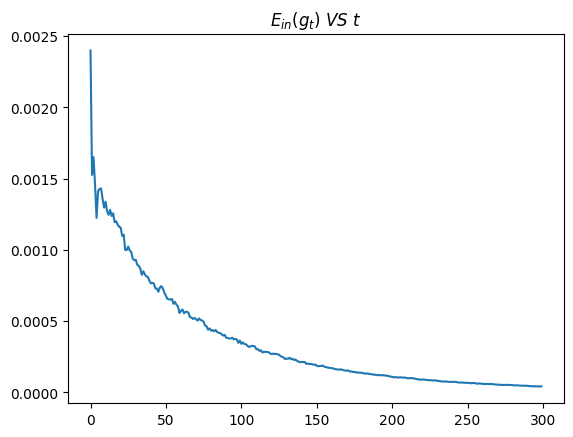

Ein(g1) = 0.0024000000000000002 ,alpha1 = 0.5763397549691928


In [29]:
Err,U,Epsilon,Alpha,G = adaboost(X,Y,theta,iterations=300)

#problem 12
t = np.arange(iterations)
plt.plot(t, Err)
plt.title("$E_{in}(g_t)\ VS\ t$")
plt.show()
print("Ein(g1) =", Err[0], ",alpha1 =", Alpha[0])

In [39]:
# Q13
g_index = np.argmin(Err)
print(Err[g_index])

4.129919777177572e-05


In [36]:
# Q14
print(np.sum(U[1]))

0.654503963774469


In [40]:
#Q15
print(np.sum(U[g_index]))

0.009541752312862391


In [4]:
test_data = np.loadtxt('hw6_adaboost_test.dat')
X_test = test_data[:,:-1]
Y_test = test_data[:,-1]


In [ ]:

s = G[:,0]
d = G[:,1]
theta_ = G[:,2]

g=[]
for i in range(iterations):
    s1 = s[i]
    d1 = d[i]
    t1 = theta_[i]

    g.append(np.mean(s1*np.sign(test_data[:,d1]-theta[:,d1][t1])!=Y_test))

print(g[0])

plt.plot(t, g)
plt.title('$E_{out}(g_1)$ VS t')
plt.show()

In [45]:
print(g[-1])

0.267


In [49]:
# 19-20
data = np.loadtxt('hw6_19_20_train.dat')
from scipy.linalg import inv

In [50]:
def generateK(X1, X2, gamma):
    """
    返回X1，X2
    """
    d1 = np.sum(X1 ** 2, axis=1).reshape(-1, 1)
    d2 = np.sum(X2 ** 2, axis=1).reshape(1, -1)
    dist = d1 + d2 - 2 * X1.dot(X2.T)
    K = np.exp(- gamma * dist)
    return K
n = int(data.shape[0] * 0.8)
m = data.shape[0] - n
#划分测试集训练集
trainx = data[:n,:][:, :-1]
trainy = data[:n,:][:, -1]
testx = data[n:,:][:, :-1]
testy = data[n:,:][:, -1]
#初始化参数
Gamma = [32, 2, 0.125]
Lambda = [0.001, 1, 1000]
#记录最优解
gammatrain = Gamma[0]
lambdatrain = Lambda[0]
gammatest = Gamma[0]
lambdatest = Lambda[0]
Ein = 1
Eout = 1
for i in Gamma:
    #计算核矩阵
    K = generateK(trainx, trainx, i)
    K1 = generateK(testx, trainx, i)
    for j in Lambda:
        #计算beta
        beta = inv(np.eye(n)*j + K).dot(trainy)
        #计算预测结果
        y1 = K.dot(beta)
        y2 = K1.dot(beta)
        ein = np.mean(np.sign(y1) != trainy)
        eout = np.mean(np.sign(y2) != testy)
        #更新最优解
        if(ein < Ein):
            Ein = ein
            gammatrain = i
            lambdatrain = j
        if(eout < Eout):
            Eout = eout
            gammatest = i
            lambdatest = j
#### Problem 19
print("minimum Ein =", Ein)
print("gamma =", gammatrain)
print("lambda =", lambdatrain)

minimum Ein = 0.0
gamma = 32
lambda = 0.001


In [51]:
print("minimum Eout =", Eout)
print("gamma =", gammatest)
print("lambda =", lambdatest)

minimum Eout = 0.39
gamma = 0.125
lambda = 1000


90


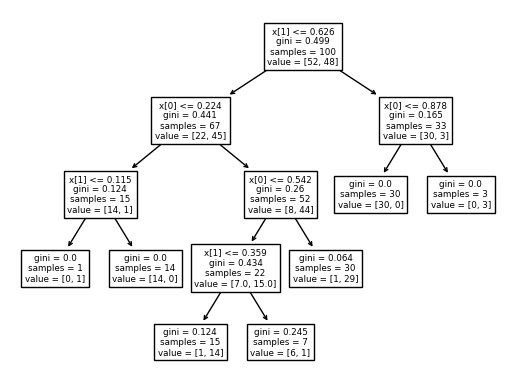

In [10]:
from sklearn import tree
clf  =tree.DecisionTreeClassifier()
clf = clf.fit(X,Y)
tree.plot_tree(clf)
Y_predict=clf.predict(X_test)
error_num = np.sum(np.where(Y_predict!=Y_test,1,0))
print(error_num)